In [1]:
using PyPlot, Printf, DelimitedFiles, JuliennedArrays

In [2]:
include("decode.jl")
include("utils.jl")
include("updateRule.jl")
include("readData.jl")
include("regression.jl");

In [3]:
using MATLAB

function initMatlab()
    spmpath = "C:\\Users\\antho\\Documents\\MATLAB\\spm12"
    mat"""addpath($spmpath)"""
end

function BMS(lme) 
    mat"""[$alpha, $exp_r, $xp, $pxp, $bor] = spm_BMS($lme)"""
    return alpha, exp_r, xp, pxp, bor
end

initMatlab()
;

In [4]:
function exportBIC(BIC, filename)
    f = matopen("ckpt/$filename", "w")
    write(f, "F", BIC)
    close(f)
end

function importBIC(filename)
    f = matopen("ckpt/$filename", "r")
    F = read(f, "F")
    close(f)
    
    return F
end
;

In [47]:
function computeSigma2(X::Array{Float64,2}, y::Array{Float64,1})
    return deviance(fit(LinearModel, X, y)) / length(y)
end
function computeSigma2ByBlock(X::Array{Float64,2}, y::Array{Float64,1}, blocks = 4)
    err = (predict(fit(LinearModel, X, y)) - y) .^ 2
    return map(b -> mean(err[X[:,b] .== 1]), 1:blocks)
end


function computeRSS(X::Array{Float64,2}, y::Array{Float64,1})
    return deviance(fit(LinearModel, X, y))
end
function computeRSSByBlock(X::Array{Float64,2}, y::Array{Float64,1}, blocks = 4)
    rss = zeros(blocks)
    for block in 1:blocks
        xblock = X[X[:,block] .== 1,end]
        yblock = y[X[:,block] .== 1]
        rss[block] = deviance(fit(LinearModel, hcat(ones(length(xblock)), xblock), yblock))
    end
    return rss
end


function computeBIC(sigma2::Float64, n::Int, k = 6)
    return n * log(sigma2) + k * log(n)
end

function computeBIC(sigma2::Array{Float64,1}, n::Array{Int,1}, k = 6)
    return n .* log.(sigma2) .+ k * log.(n)
end
;

In [6]:
function mapBIC(subject, models, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, keepBlockLevel, verbose)
    
    if verbose > 1
        lg("mapBIC: computing RSS...")
    end
    
    (Ntrials, Nsensors, _) = size(megs)
    pBICs = Array{Array{Float64,1},2}(undef, length(slices), length(models))
    mBICs = zeros(length(slices), length(models))
    
    # regress for each slice
    for slice in eachindex(slices)
        Ntimes = length(slices[slice])
        
        # regress for each model
        for model in eachindex(surprises)
            
            # regress for each sensor and time
            RSSs = zeros(length(surprises[model]), Nsensors, Ntimes)

            for s in 1:Nsensors, t in 1:Ntimes
                y = megs[:,s,slices[slice][t]]
                y = (y .- mean(y)) ./ std(y)

                RSSs[:,s,t] = computeRSS.(surprises[model], Ref(y)) 
            end

            # compute BIC by parameter
            pBICs[slice,model] = @pipe RSSs |> 
                                       sum(_, dims=(2,3)) |> 
                                       dropdims(_, dims=(2,3)) |>
                                       computeBIC.(_ / Ntrials, Ntrials)

            # compute BIC by model
            mBICs[slice,model] = @pipe RSSs |> 
                                       sum |> 
                                       computeBIC(_ / Ntrials, Ntrials)
        end
    end

    return pBICs, mBICs
end
;

In [7]:
function mapBICByBlock(subject, models, slices, keepBlockLevel = true, verbose=2)
    surprises, megs = mapSubject(subject, models, keepBlockLevel, verbose)
    
    if verbose > 1
        lg("mapBICByBlock: computing RSS...")
    end
    
    blocks = 4
    Nsensors = size(megs, 2)
    Ns = map(b -> length(findnz(surprises[1][1][:,b])), 1:blocks)
    
    pBICs = Array{Array{Float64,1},3}(undef, length(slices), length(models), blocks)
    mBICs = zeros(length(slices), length(models), blocks)
    
    # regress for each slice
    for slice in eachindex(slices)
        Ntimes = length(slices[slice])
        
        # regress for each model
        for model in eachindex(surprises)
            
            # regress for each sensor, time, and block
            RSSs = zeros(length(surprises[model]), Nsensors, Ntimes, blocks)

            for s in 1:Nsensors, t in 1:Ntimes
                y = megs[:,s,slices[slice][t]]
                y = (y .- mean(y)) ./ std(y)
                
                RSSs[:,s,t,:] = computeRSSByBlock.(surprises[model], Ref(y), blocks) |> arrayOfArrayToMatrix
            end

            # compute BIC by parameter
            for b in 1:blocks
                pBICs[slice,model,b] = @pipe RSSs[:,:,:,b] |> 
                                             sum(_, dims=(2,3)) |> 
                                             dropdims(_, dims=(2,3)) |>
                                             computeBIC.(_ / Ns[b], Ns[b])

                # compute BIC by model
                mBICs[slice,model,b] = @pipe RSSs[:,:,:,b] |> 
                                             sum |> 
                                             computeBIC(_ / Ns[b], Ns[b])
            end
        end
    end
        
    return pBICs, mBICs
end
;

In [8]:
function getBICForSubjects(subjects, models, slices, keepBlockLevel = true,
        verbose = 1, fromMat = false)
    
    # init empty BIC containers
    pBICs = Array{Array{Float64,1},3}(undef, length(subjects), length(slices), length(models))
    mBICs = zeros(length(subjects), length(slices), length(models))
    
    for subIdx in eachindex(subjects)
        subName = subjects[subIdx]
        if verbose > 0
            lg("Loading data for subject $subName...")
        end
        
        # load subject
        if fromMat
            sub = loadSubjectData(getFilename(subName))
        else
            sub = loadJLD2(getJLD2Filename(subName))
        end
        
        # compute BIC
        pBIC, mBIC = mapBIC(sub, models, slices, keepBlockLevel, verbose)
            
        @inbounds pBICs[subIdx,:,:] = pBIC
        @inbounds mBICs[subIdx,:,:] = mBIC
        
        if verbose > 1
            println("")
        end
    end
    
    # reshape according to slices first
    pBICs = permutedims(pBICs, (2, 1, 3))
    mBICs = permutedims(mBICs, (2, 1, 3))
    
    # save 
    dt = Dates.format(now(), "dd-mm-HH-MM")
    exportBIC(pBICs, "pBICs_$dt.mat")
    exportBIC(mBICs, "mBICs_$dt.mat")
    
    return pBICs, mBICs
end
;

In [9]:
function getBICByBlockForSubjects(subjects, models, slices, keepBlockLevel = true, verbose = 1)
    
    # init empty BIC containers
    blocks = 4
    pBICs = Array{Array{Float64,1},4}(undef, length(subjects), length(slices), length(models), blocks)
    mBICs = zeros(length(subjects), length(slices), length(models), blocks)
    
    for subIdx in eachindex(subjects)
        subName = subjects[subIdx]
        if verbose > 0
            lg("Loading data for subject $subName...")
        end
        
        # load subject
        sub = loadJLD2(getJLD2Filename(subName))
        
        # compute BIC
        pBIC, mBIC = mapBICByBlock(sub, models, slices, keepBlockLevel, verbose)
            
        @inbounds pBICs[subIdx,:,:,:] = pBIC
        @inbounds mBICs[subIdx,:,:,:] = mBIC
        
        if verbose > 1
            println("")
        end
    end
    
    # reshape according to blocks first, then slices, then subjects, then rules / models
    pBICs = permutedims(pBICs, (4, 2, 1, 3))
    mBICs = permutedims(mBICs, (4, 2, 1, 3))
    
    # save 
    dt = Dates.format(now(), "dd-mm-HH-MM")
    exportBIC(pBICs, "pBICsBlock_$dt.mat")
    exportBIC(mBICs, "mBICsBlock_$dt.mat")
    
    return pBICs, mBICs
end
;

In [10]:
function computeBMS(mBICs)
    function mapBIC(bic)
        alpha, exp_r, xp, pxp, bor = BMS(-bic/2.0)
        return exp_r[1,:], xp[1,:]
    end
    
    initMatlab()
    return map(mapBIC, Slices(mBICs, 2, 3))
end

function computePosterior(pBICs)
    posterior = similar(pBICs)
    
    for i in 1:size(posterior,1)
        expPBICs = map(s -> exp.(-(s .- mean(s))/2.0), Slices(pBICs[i,:,:], 2))
        sums = map(sum, expPBICs)

        expPBICs = arrayOfArrayToMatrix(expPBICs)
        posterior[i,:,:] = expPBICs ./ sums
    end
    
    return posterior
end
;

In [11]:
function fig5D(mBICs, models, sliceNames, modelNames=[])
    # compute BMS
    bms = computeBMS(mBICs)

    # create plot
    fig = figure("Different learnt statistics", figsize=(11,3))
    
    # map models to labels
    if length(modelNames) == 0
        modelNames = map(m -> m[1]["name"], models)
    end
    x = collect(1:length(modelNames))

    for i in 1:size(mBICs,1)
        ax = subplot(130 + i)

        # plot
        bar(x, bms[i][1], tick_label=modelNames, color=["#2980b9", "#e74c3c"])

        # add title
        PyPlot.title(@sprintf("Time window %i \n (%s)", i, sliceNames[i]))
        xlabel("Models")
        if i == 1
            ylabel("Posterior probability")
        end

        # annotate exceedance prob
        val, idx = findmax(bms[i][2])
        strval = @sprintf("%.2f", val)
        phi = latexstring("\$\\varphi = $strval\$")

        text = annotate(phi, xy=[x[idx] - 0.08; 0.3], xycoords="data", color="w", fontsize=14)
        text.set_rotation(90)

        ax.set_ylim([0, 1])
    end
    
    return fig
end
;

In [12]:
function fig5E(params, pBICs, sliceNames)
    # figure from paper
    
    # we assume there are the same number of rules per model
    BICs = zeros(size(pBICs,1), size(pBICs,2), size(pBICs,3)*length(pBICs[1,1,1]))
    for slice in 1:size(pBICs,1)
        for subject in 1:size(pBICs,2)
            BICs[slice,subject,:] = vcat(pBICs[slice,subject,:]...)
        end
    end
    
    # compute posterior probabilites
    posterior = computePosterior(BICs)
    
    # sum matching parameters
    paramPosterior = zeros(size(pBICs,1), size(pBICs,2), length(params))
    for i in 1:size(paramPosterior,1), j in 1:size(paramPosterior,3)
        
        # iterate over models
        value = 0
        for m in 1:size(pBICs,3)
            value = value .+ posterior[i,:,j+(m-1)*length(params)]
        end
        
        paramPosterior[i,:,j] = value
    end

    # map to inter-subject mean
    paramPosterior = permutedims(paramPosterior, (2,1,3))
    means = @pipe map(mean, Slices(paramPosterior, 1)) |> 
            arrayOfArrayToMatrix

    sterr = @pipe map(slice -> std(slice) / sqrt(length(slice)), Slices(paramPosterior, 1)) |> 
            arrayOfArrayToMatrix

    # create plot   
    fig = figure("Different integration horizons", figsize=(12,3))

    for i in 1:size(means,1)
        ax = subplot(130 + i)
        # plot posterior timecourse
        semilogx(ws, 1e2 * means[i,:], "k", lw=2)
        fill_between(ws, 1e2 * (means[i,:] - sterr[i,:]), 1e2 * (means[i,:] + sterr[i,:]), color="0.75", alpha=0.4)

        # add title
        PyPlot.title(@sprintf("Time window %i \n (%s)", i, sliceNames[i]))
        xlabel(L"Timescale of integration ($\omega$)")
        if i == 1
            ylabel(L"Posterior probability ($10^{-2}$)")
        end
        
        #gca().set_xticks(map(w -> w == Inf ? L"$\infty$" : string(w), ws))

        # annotate max value
        val, idx = findmax(means[i,:])
        x = ws[idx] == Inf ? ws[end-1] : ws[idx]
        y = ws[idx] == Inf ? means[i,end-1] : means[i,idx]
        y = 1e2 * y
        
        xtext = ws[idx] == Inf ? 0.5*x : 2*x
        ytext = y + 0.1

        str = ws[idx] == Inf ? L"$\omega = \infty$" : latexstring("\$\\omega = $(Int(ws[idx]))\$")

        scatter(x, y, color="w", edgecolors="k", s=60, zorder=1)
        annotate(str, xy=[x; y], xytext=[xtext; ytext], xycoords="data")

        ax.set_ylim([1.5, 2.2])
    end
    
    return fig
end
;

In [13]:
function fig5EHeat(params, models, pBICs, sliceNames)
    # heatmap
    
    # we assume there are the same number of rules per model
    BICs = zeros(size(pBICs,1), size(pBICs,2), size(pBICs,3)*length(pBICs[1,1,1]))
    for slice in 1:size(pBICs,1)
        for subject in 1:size(pBICs,2)
            BICs[slice,subject,:] = vcat(pBICs[slice,subject,:]...)
        end
    end
    
    # compute posterior probabilites
    posterior = computePosterior(BICs)

    # map to inter-subject mean
    posterior = permutedims(posterior, (2,1,3))
    means = @pipe map(slice -> mean(slice, dims=1), Slices(posterior, 1)) |> 
                  arrayOfArrayToMatrix |> 
                  dropdims(_, dims=1)

    vmin = findmin(means)[1]
    vmax = findmax(means)[1]
    
    # find number of window lengths
    names = map(m -> unique(map(rule -> rule["name"], m)), reverse(models))
    Nm = length(names[1])
    names = vcat(names...)
    
    step = 11
    xticks = @pipe 1:step:length(params[1]) |> collect |> vcat(_, [length(params[1])-1])
    xlabels = @pipe params[1][1:step:end] |> 
                    Int.(_) |> 
                    string.(_) |> 
                    vcat(_, [L"\infty"])
    
    if length(params) == 2 && params[1] != params[2]
        use2Axes = true
        step2 = step
        xticks2 = @pipe 1:step2:length(params[2]) |> 
                        collect |> 
                        vcat
        
        xlabels2 = @pipe params[2][1:step:end] |>
                         map(p -> @sprintf("%.3f", p), _) |>
                         vcat
    else
        use2Axes = false
        xticks2 = []
        xlabels2 = []
    end
    aspect = 2 * 7.8 / Nm

    # create plot
    fig = figure("Different integration horizons", figsize=(12,2))
    heatmap = undef

    for i in 1:size(means,1)
        ax = subplot(130 + i)
        ax.set_xlim([0, length(params[1])])
        
        if use2Axes
            ax2 = ax.twiny()
            ax2.set_xlim([0, length(params[1])])
        end
        
        # plot
        values = reshape(means[i,:], (length(params[1]), Nm * length(models)))
        values = hcat(values[:,Nm+1:end], values[:,1:Nm])
        heatmap = ax.imshow(values',
            cmap="rainbow",
            interpolation="nearest",
            #extent=[-0.5, length(params[1])-0.5, -0.5, Nm * length(models) - 0.5],
            vmin=vmin,
            vmax=vmax)
        
        # set x and y axis labels
        ax.set_aspect(aspect)
        ax.set_xlabel(L"Timescale of integration ($\omega$)")
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels)
        
        # add second axis
        if use2Axes
            ax2.set_aspect(aspect)            
            ax2.set_xlabel(L"Change probability ($m_c = \frac{p_c}{1 - p_c}$)")
            ax2.set_xticks(xticks2)
            ax2.set_xticklabels(xlabels2)
        end
        
        # set y axis
        if i == 1
            ax.set_ylabel(L"Model")
            ax.set_yticks(collect(1:(Nm*length(models))) .- 1)
            ax.set_yticklabels(names)
        else
            ax.set_yticks([])
        end

        # colorbar at the end
        """if i == size(means,1)
            cbar = colorbar(heatmap, aspect=ratio, shrink=0.46)
            rnd(x) = @sprintf("%.3f", x)
            vals = [vmin,(vmin+vmax)/2.0,vmax]
            cbar.set_ticks(vals)
            cbar.set_ticklabels(rnd.(vals))
        end
        """
                
        # add title
        PyPlot.title(@sprintf("Time window %i \n (%s)", i, sliceNames[i]))

        # annotate max value
        #"""
        #val, idx = findmax(means[i,:])
        #x = ws[idx] == Inf ? ws[end-1] : ws[idx]
        #y = ws[idx] == Inf ? means[i,end-1] : means[i,idx]
        #y = 1e2 * y

        #str = ws[idx] == Inf ? L"$\omega = \infty$" : latexstring("\$\\omega = $(Int(ws[idx]))\$")

        #scatter(x, y, color="w", edgecolors="k", s=60)
        #annotate(str, xy=[x; y], xytext=[10; 10], xycoords="data")

        #ax.set_ylim([6.5, 10.5])
        #""";
    end
    
    cbaxes = fig.add_axes([0.95, 0.1, 0.02, 0.8]) 
    cbar = colorbar(heatmap, shrink=0.46, cax=cbaxes)
    rnd(x) = @sprintf("%.3f", x)
    vals = [vmin,(vmin+vmax)/2.0,vmax]
    cbar.set_ticks(vals)
    cbar.set_ticklabels(rnd.(vals))
    
    return fig
end
;

In [14]:
function build_slices()
    slices = [
        80:98,   #  60 to 130 ms
        106:147, # 160 to 320 ms
        183:225  # 460 to 625 ms
    ]
    
    sliceNames = [
        "60 to 130 ms",
        "160 to 320 ms",
        "460 to 625 ms"
    ]
    
    return slices, sliceNames
end
;

## Leaky

In [166]:
# leaky
ws = vcat(log2range(0, 10, 54), [Inf])
leaky_rules = build_rules_leaky(ws)
leaky_models = build_models(leaky_rules, [0,1])

# slices
slices, sliceNames = build_slices()

# subjects
subjects = 1:18

# keep block level
keepBlockLevel = true

# do computation
verbose = 1
fromMat = false
;

In [162]:
mBICsLeaky = importBIC("leaky/mBICs.mat")
pBICsLeaky = importBIC("leaky/pBICs.mat")
;

In [22]:
pBICsLeaky, mBICsLeaky = getBICForSubjects(subjects, leaky_models, slices,
    keepBlockLevel, verbose, fromMat)
;

[2020-04-24T19:24:49.094] Loading data for subject 1...
[2020-04-24T19:41:50.961] Loading data for subject 2...
[2020-04-24T20:03:02.69] Loading data for subject 3...
[2020-04-24T20:27:05.891] Loading data for subject 4...
[2020-04-24T20:30:53.135] Loading data for subject 5...
[2020-04-24T20:34:58.792] Loading data for subject 6...
[2020-04-24T20:39:11.628] Loading data for subject 7...
[2020-04-24T20:43:53.418] Loading data for subject 8...
[2020-04-24T20:49:40.56] Loading data for subject 9...
[2020-04-24T20:54:57.509] Loading data for subject 10...
[2020-04-24T21:00:57.275] Loading data for subject 11...
[2020-04-24T21:05:26.993] Loading data for subject 12...
[2020-04-24T21:10:06.987] Loading data for subject 13...
[2020-04-24T21:14:06.244] Loading data for subject 14...
[2020-04-24T21:18:13.5] Loading data for subject 15...
[2020-04-24T21:22:37.063] Loading data for subject 16...
[2020-04-24T21:26:54.962] Loading data for subject 17...
[2020-04-24T21:30:42.126] Loading data for s

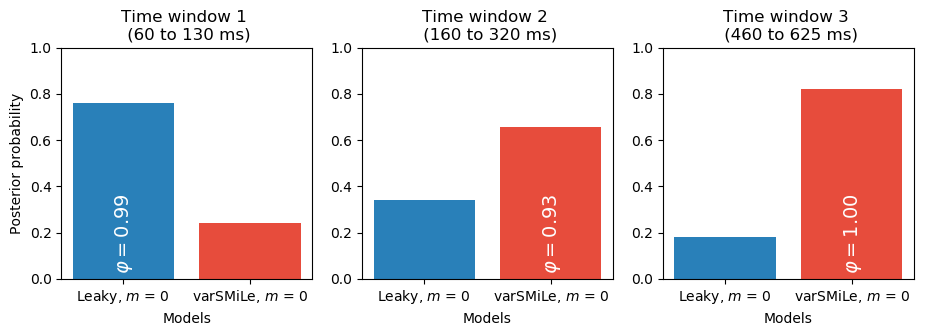

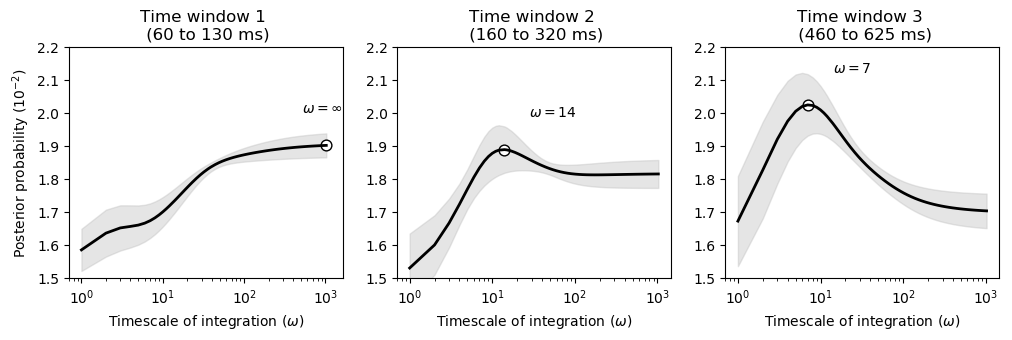

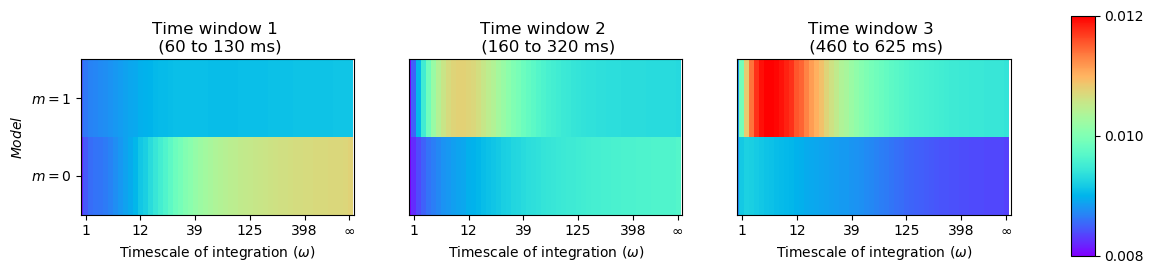

In [169]:
fig = fig5D(mBICsLeaky, leaky_models, sliceNames)
display(fig)
clf()

fig = fig5E(ws, pBICsLeaky, sliceNames)
display(fig)
clf()

fig = fig5EHeat([ws], leaky_models, pBICsLeaky, sliceNames)
display(fig)
clf()

## Compare Leaky and VarSMiLe

In [ ]:
# todo: test if pBICs is not sum across same w before computing BIC

In [18]:
window_lengths = [0,1,2]

# leaky
ws = vcat(log2range(0, 10, 54), [Inf])
leaky_rules = build_rules_leaky(ws)
leaky_names = [L"Leaky, $m$ = 0", L"Leaky, $m$ = 1", L"Leaky, $m$ = 2"]
leaky_models = build_models(leaky_rules, window_lengths, leaky_names)
leaky_models = vcat(leaky_models...)

# varsmile
ms = 1 .- exp.(- 1 ./ ws)
varsmile_rules = build_rules_varsmile(ms)
varsmile_names = [L"varSMiLe, $m$ = 0", L"varSMiLe, $m$ = 1", L"varSMiLe, $m$ = 2"]
varsmile_models = build_models(varsmile_rules, window_lengths, varsmile_names)
varsmile_models = vcat(varsmile_models...)

# models
models = [leaky_models, varsmile_models]

# slices
slices, sliceNames = build_slices()

# subjects
subjects = 1:18

# keep block level
keepBlockLevel = true

# do computation
verbose = 2
fromMat = false
;

In [20]:
# m = 0,1
mBICs = importBIC("mBICs_all_01.mat")
pBICs = importBIC("pBICs_all_01.mat")
;

In [ ]:
# m = 0,1,2
mBICs = importBIC("mBICs_all_012.mat")
pBICs = importBIC("pBICs_all_012.mat")
;

In [19]:
pBICs, mBICs = getBICForSubjects(subjects, models, slices,
    keepBlockLevel, verbose, fromMat)
;

[2020-04-27T02:59:03.776] Loading data for subject 1...
[2020-04-27T02:59:08.952] mapSubject: decoding sequence for all rules
[2020-04-27T02:59:10.774] mapSubject: decoding MEG
[2020-04-27T02:59:12.321] mapBIC: computing RSS...

[2020-04-27T03:06:00.63] Loading data for subject 2...
[2020-04-27T03:06:05.457] mapSubject: decoding sequence for all rules
[2020-04-27T03:06:06.728] mapSubject: decoding MEG
[2020-04-27T03:06:08.019] mapBIC: computing RSS...

[2020-04-27T03:12:47.191] Loading data for subject 3...
[2020-04-27T03:12:52.07] mapSubject: decoding sequence for all rules
[2020-04-27T03:12:53.358] mapSubject: decoding MEG
[2020-04-27T03:12:54.739] mapBIC: computing RSS...

[2020-04-27T03:18:51.975] Loading data for subject 4...
[2020-04-27T03:18:57.195] mapSubject: decoding sequence for all rules
[2020-04-27T03:18:58.483] mapSubject: decoding MEG
[2020-04-27T03:18:59.941] mapBIC: computing RSS...

[2020-04-27T03:25:29.388] Loading data for subject 5...
[2020-04-27T03:25:34.656] mapS

### $m = 0, 1$

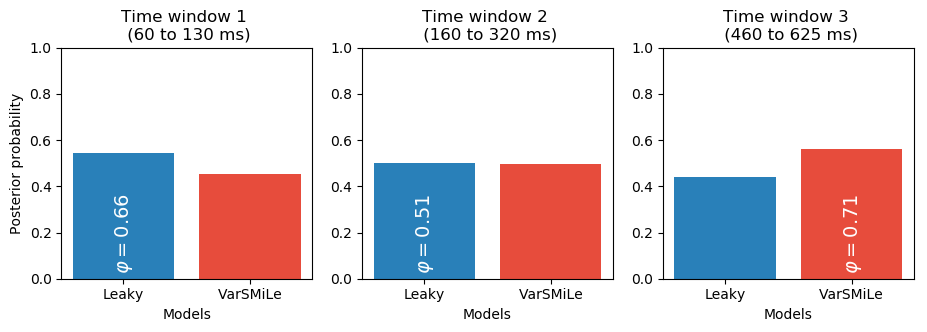

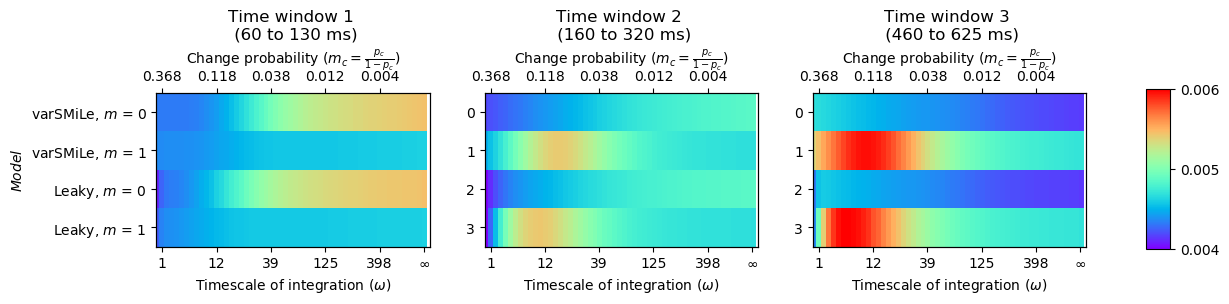

In [128]:
modelNames = ["Leaky", "VarSMiLe"]
fig = fig5D(mBICs, models, sliceNames, modelNames)
display(fig)
clf()

fig5EHeat([ws, ms], models, pBICs, sliceNames)
;

### $m = 0,1,2$

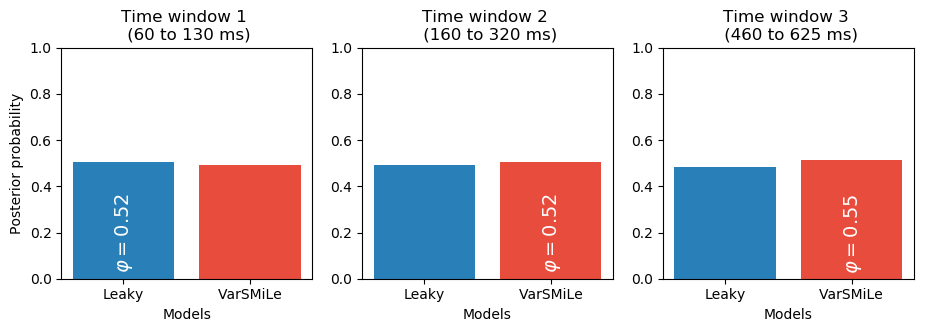

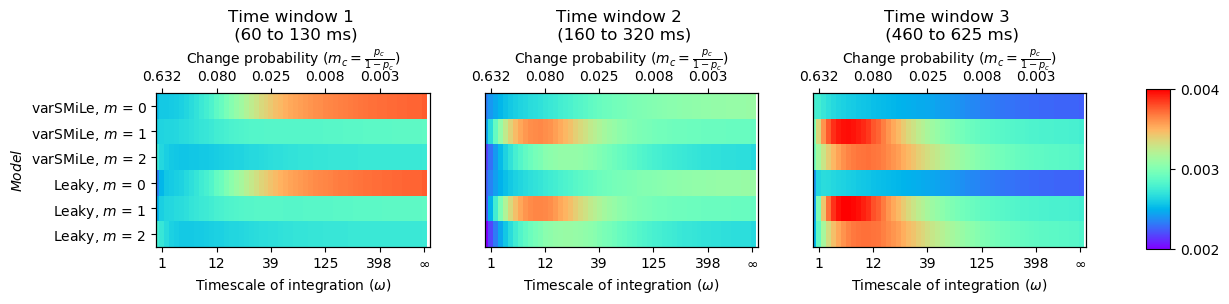

In [20]:
modelNames = ["Leaky", "VarSMiLe"]
fig = fig5D(mBICs, models, sliceNames, modelNames)
display(fig)
clf()

fig5EHeat([ws, ms], models, pBICs, sliceNames)
;

## Leaky by block

In [41]:
# leaky
ws = vcat(log2range(0, 10, 54), [Inf])
leaky_rules = build_rules_leaky(ws)
leaky_models = build_models(leaky_rules, [0,1])

# slices
slices, sliceNames = build_slices()

# subjects
subjects = 1:18

# do computation
verbose = 2
;

In [39]:
pBICsByBlock = importBIC("pBICsBlock_dep.mat")
mBICsByBlock = importBIC("mBICsBlock_dep.mat")
;

In [ ]:
pBICsByBlock = importBIC("pBICsBlock_indep.mat")
mBICsByBlock = importBIC("mBICsBlock_indep.mat")
;

In [48]:
pBICsByBlock, mBICsByBlock = getBICByBlockForSubjects(subjects, leaky_models, slices, 
    true, verbose)
;

[2020-04-27T09:13:56.717] Loading data for subject 1...
[2020-04-27T09:13:58.731] mapSubject: decoding sequence for all rules
[2020-04-27T09:13:59.102] mapSubject: decoding MEG
[2020-04-27T09:14:00.687] mapBICByBlock: computing RSS...

[2020-04-27T09:19:25.552] Loading data for subject 2...
[2020-04-27T09:19:30.509] mapSubject: decoding sequence for all rules
[2020-04-27T09:19:30.872] mapSubject: decoding MEG
[2020-04-27T09:19:32.359] mapBICByBlock: computing RSS...

[2020-04-27T09:24:26.056] Loading data for subject 3...
[2020-04-27T09:24:31.606] mapSubject: decoding sequence for all rules
[2020-04-27T09:24:32.151] mapSubject: decoding MEG
[2020-04-27T09:24:34.83] mapBICByBlock: computing RSS...

[2020-04-27T09:29:37.643] Loading data for subject 4...
[2020-04-27T09:29:42.606] mapSubject: decoding sequence for all rules
[2020-04-27T09:29:42.961] mapSubject: decoding MEG
[2020-04-27T09:29:44.58] mapBICByBlock: computing RSS...

[2020-04-27T09:35:23.29] Loading data for subject 5...
[20

[2020-04-27T10:51:59.431] BLOCK 1


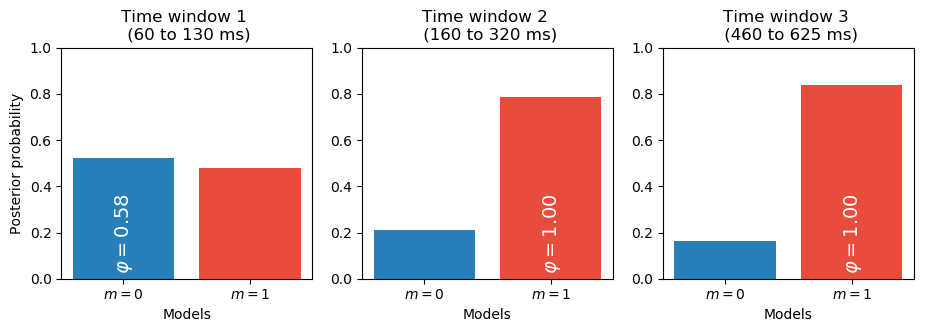

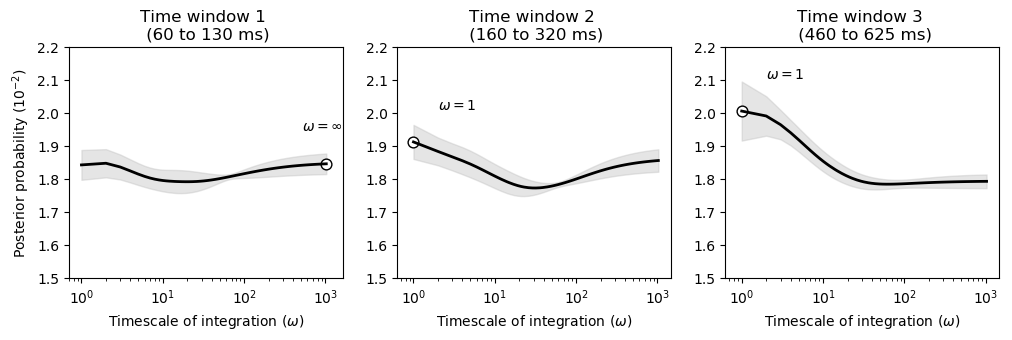

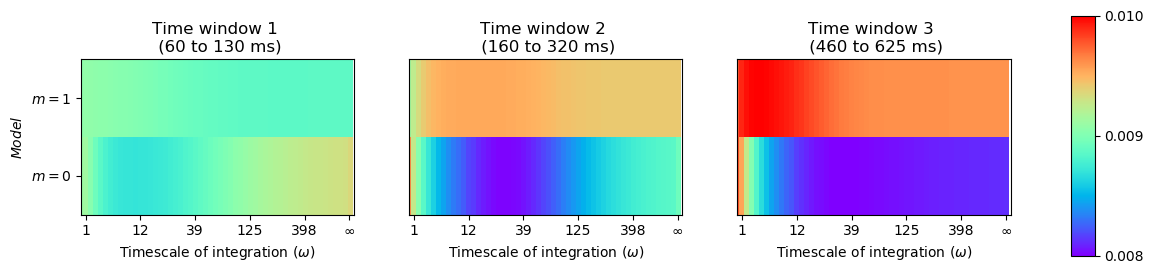

[2020-04-27T10:52:02.289] BLOCK 2


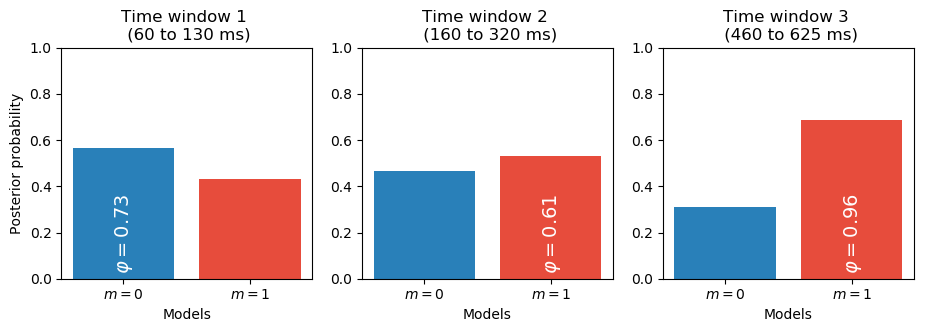

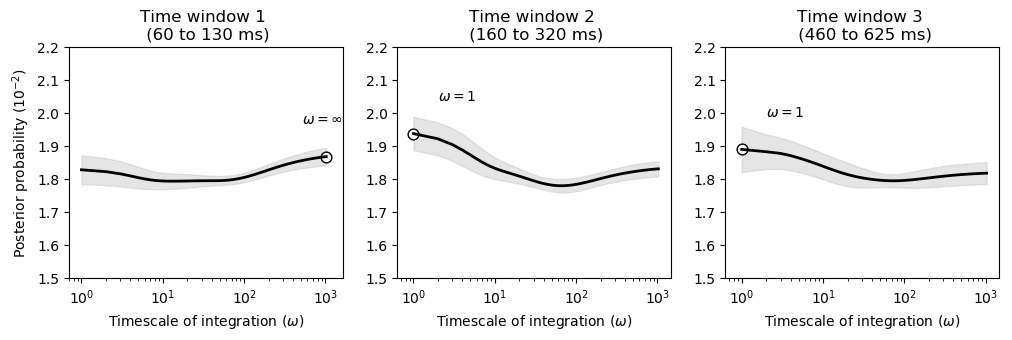

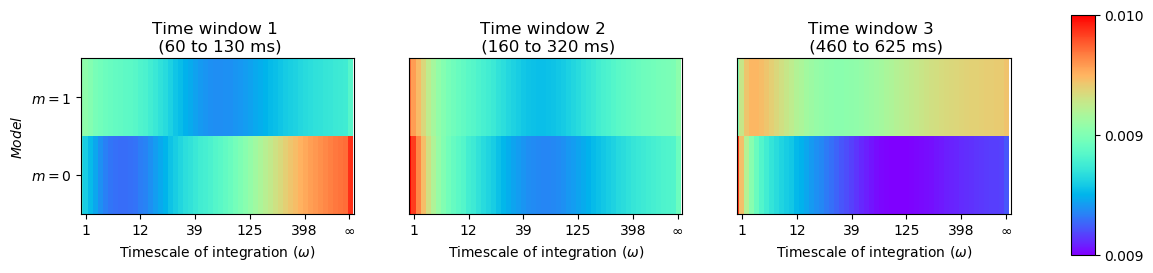

[2020-04-27T10:52:04.536] BLOCK 3


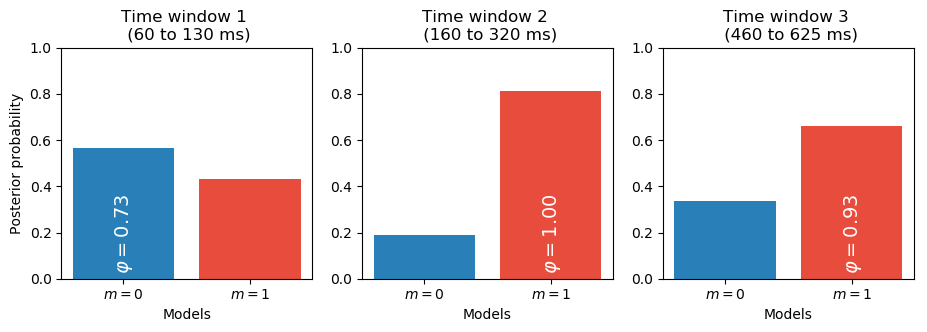

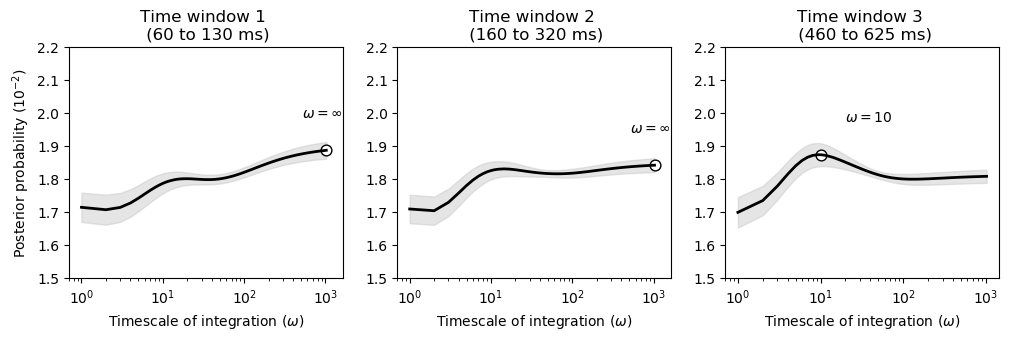

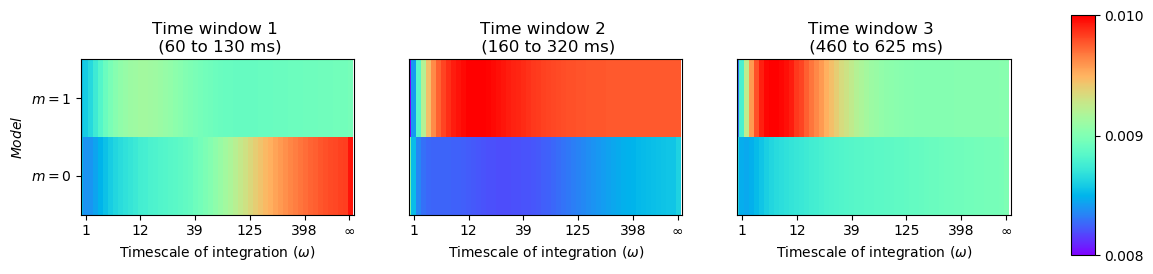

[2020-04-27T10:52:06.76] BLOCK 4


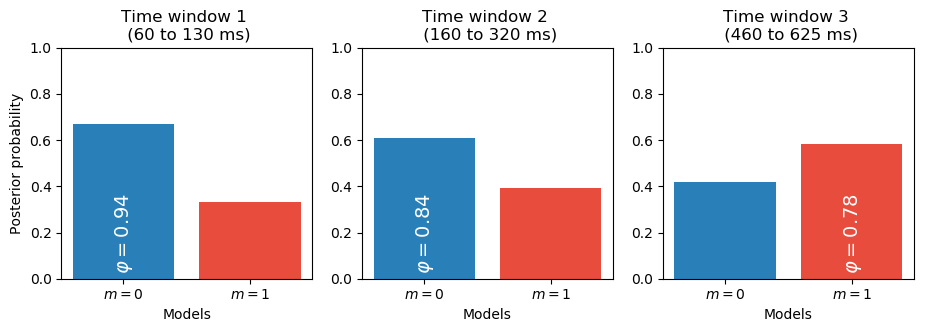

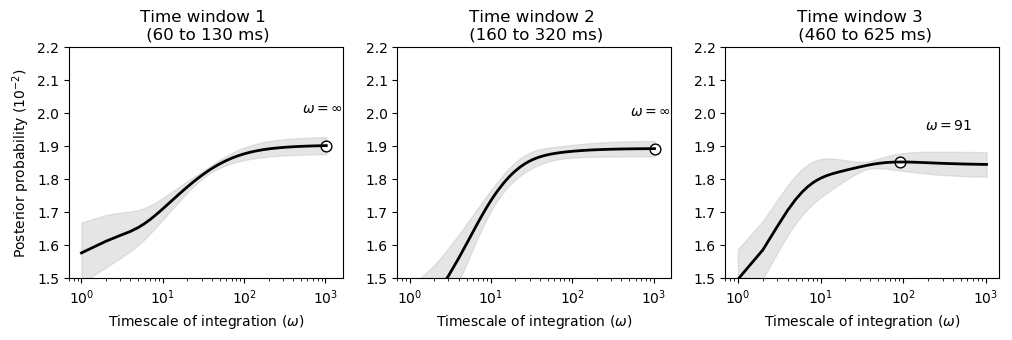

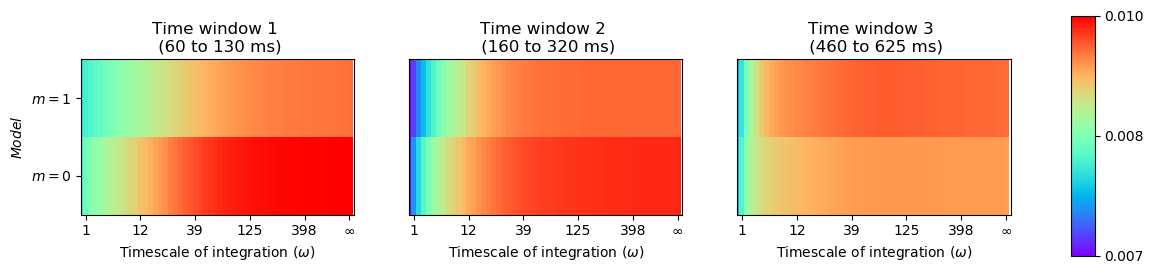

In [49]:
blocks = 4
for block in 1:blocks
    lg("BLOCK $block")
    
    fig = fig5D(mBICsByBlock[block,:,:,:], leaky_models, sliceNames)
    display(fig)
    clf()

    fig = fig5E(ws, pBICsByBlock[block,:,:,:], sliceNames)
    display(fig)
    clf()

    fig = fig5EHeat([ws], leaky_models, pBICsByBlock[block,:,:,:], sliceNames)
    display(fig)
    clf()
end

In [38]:
function mapBIC4(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, keepBlockLevel, verbose)
    
    if verbose > 1
        lg("mapBIC4: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    sensorBICs = zeros(size(megs,2), length(surprises))
    
    for s in eachindex(slices)
        # average over all times in slice
        yavg = @pipe mean(megs[:,:,slices[s]], dims=3) |> # mean over time
                     dropdims(_, dims=3)                  # drop time dim
        
        # regress for each sensor
        for sensor in 1:size(yavg,2)
            sensorBICs[sensor,:] = @pipe surprises |> 
                                         computeSigma2.(_, Ref(yavg[:,sensor])) # map to sigma2
        end
        
        # find min sigma2 for sensor and time for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = @pipe findmin(sensorBICs[:,mFrom:mTo], dims=2) |> dropdims(_[1], dims=2) |> mean |> computeBIC(_, N)
            mFrom += mIncr
            mTo += mIncr
        end
        
        # average sigma2 for each sensor and time, then compute BIC
        wBICs[s,:] = @pipe mean(sensorBICs, dims=1) |> 
                           dropdims(_, dims=1) |>
                           computeBIC.(_, N)
    end
    
    return wBICs, mBICs
end

# change to take BIC of mean
function mapBIC5(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, keepBlockLevel, verbose)
    
    if verbose > 1
        lg("mapBIC5: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    sensorBICs = zeros(size(megs,2), length(surprises))
    
    for s in eachindex(slices)
        # average over all times in slice
        yavg = @pipe mean(megs[:,:,slices[s]], dims=3) |> # mean over time
                     dropdims(_, dims=3)                  # drop time dim
        
        # regress for each sensor
        for sensor in 1:size(yavg,2)
            sensorBICs[sensor,:] = @pipe surprises |> 
                                         computeSigma2.(_, Ref(yavg[:,sensor])) # map to sigma2
        end
        
        # find min sigma2 for sensor and time for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = @pipe findmin(sensorBICs[:,mFrom:mTo], dims=2) |> dropdims(_[1], dims=2) |> computeBIC.(_, N) |> mean
            mFrom += mIncr
            mTo += mIncr
        end
        
        # BIC
        wBICs[s,:] = map(sl -> computeBIC(mean(sl), N), Slices(sensorBICs, 1))
    end
    
    return wBICs, mBICs
end

# tried big N
# like 7 but with keepBlock = true
# mod mBIC code
function mapBIC6(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, keepBlockLevel, verbose)
    
    if verbose > 1
        lg("mapBIC6: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    
    for s in eachindex(slices)
        stBICs = zeros(size(megs,2), length(slices[s]), length(surprises))
        # regress for each sensor and time
        for sensor in 1:size(megs,2), t in 1:length(slices[s])
            stBICs[sensor,t,:] = @pipe surprises |> 
                                       computeSigma2.(_, Ref(megs[:,sensor,slices[s][t]])) # map to sigma2
        end
        
        # find min sigma2 for sensor and time for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = @pipe mean(stBICs[:,:,mFrom:mTo], dims=2) |>
                                dropdims(_[1], dims=2) |>
                                findmin(_, dims=2) |> 
                                dropdims(_[1], dims=2) |> 
                                mean |>
                                computeBIC(_, N)
            mFrom += mIncr
            mTo += mIncr
        end
        
        # average sigma2 for each sensor and time, then compute BIC
        wBICs[s,:] = @pipe mean(stBICs, dims=2) |> 
                           dropdims(_, dims=2) |>
                           mean(_, dims=1) |> 
                           dropdims(_, dims=1) |>
                           computeBIC.(_, N)
    end
    
    return wBICs, mBICs
end

# tried big N
# like 8 but without 1e12
function mapBIC7(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, false, verbose)
    
    if verbose > 1
        lg("mapBIC7: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    
    for s in eachindex(slices)
        stBICs = zeros(size(megs,2), length(slices[s]), length(surprises))
        # regress for each sensor and time
        for sensor in 1:size(megs,2), t in 1:length(slices[s])
            stBICs[sensor,t,:] = @pipe surprises |> 
                                       computeSigma2.(_, Ref(megs[:,sensor,slices[s][t]])) # map to sigma2
        end
        
        # find min sigma2 for sensor and time for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = @pipe mean(stBICs[:,:,mFrom:mTo], dims=2) |> 
                               dropdims(_, dims=2) |>
                               findmin(_, dims=2) |>
                               dropdims(_[1], dims=2) |>
                               mean |>
                               computeBIC(_, N)
            
            # @pipe findmin(stBICs[:,:,mFrom:mTo], dims=3) |> dropdims(_[1], dims=3) |> mean |> computeBIC(_, N)
            
            mFrom += mIncr
            mTo += mIncr
        end
        
        # average sigma2 for each sensor and time, then compute BIC
        wBICs[s,:] = @pipe mean(stBICs, dims=2) |> 
                           dropdims(_, dims=2) |>
                           mean(_, dims=1) |> 
                           dropdims(_, dims=1) |>
                           computeBIC.(_, N)
    end
    
    return wBICs, mBICs
end

# like mapBIC7 but with lower N and 1e12, also keepblock = false
# change mBICs selection rule
function mapBIC8(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, false, verbose)
    
    if verbose > 1
        lg("mapBIC8: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    
    for s in eachindex(slices)
        stBICs = zeros(size(megs,2), length(slices[s]), length(surprises))
        # regress for each sensor and time
        for sensor in 1:size(megs,2), t in 1:length(slices[s])
            stBICs[sensor,t,:] = @pipe surprises |> 
                                       computeSigma2.(_, Ref(1e12 * megs[:,sensor,slices[s][t]])) # map to sigma2
        end
        
        # average sigma2 for each sensor and time, then compute BIC
        wBICs[s,:] = @pipe mean(stBICs, dims=2) |> 
                           dropdims(_, dims=2) |>
                           mean(_, dims=1) |> 
                           dropdims(_, dims=1) |>
                           computeBIC.(_, N)
        
        # find min sigma2 for sensor and time for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = @pipe findmin(wBICs[s,mFrom:mTo])[1]
            mFrom += mIncr
            mTo += mIncr
        end
    end
    
    return wBICs, mBICs
end

# like 4, but mean after BIC
# change to 1e12
function mapBIC9(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, keepBlockLevel, verbose)
    
    if verbose > 1
        lg("mapBIC9: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    sensorBICs = zeros(size(megs,2), length(surprises))
    
    for s in eachindex(slices)
        # average over all times in slice
        yavg = @pipe mean(1e12 * megs[:,:,slices[s]], dims=3) |> # mean over time
                     dropdims(_, dims=3)                  # drop time dim
        
        # regress for each sensor
        for sensor in 1:size(yavg,2)
            sensorBICs[sensor,:] = @pipe surprises |> 
                                         computeSigma2.(_, Ref(yavg[:,sensor])) |>
                                         computeBIC.(_, N) # map to sigma2
        end
        
        # find min BIC for sensor and time for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = @pipe findmin(sensorBICs[:,mFrom:mTo], dims=2) |> dropdims(_[1], dims=2) |> mean
            mFrom += mIncr
            mTo += mIncr
        end
        
        # average BIC for each sensor
        wBICs[s,:] = @pipe mean(sensorBICs, dims=1) |> 
                           dropdims(_, dims=1)
    end
    
    return wBICs, mBICs
end

# change to 1e12
function mapBIC10(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, keepBlockLevel, verbose)
    
    if verbose > 1
        lg("mapBIC10: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    
    for s in eachindex(slices)
        # average over all sensors and times in slice
        yavg = @pipe mean(1e12 * megs[:,:,slices[s]], dims=3) |> # mean over time
                     dropdims(_, dims=3) |>               # drop time dime
                     mean(_, dims=2) |>                   # mean over sensors
                     dropdims(_, dims=2)                  # drop sensor dim
        
        # map to BIC
        wBICs[s,:] = @pipe surprises |> 
                           computeSigma2.(_, Ref(yavg)) |> # map to sigma2
                           computeBIC.(_, N)               # map to BIC
        
        # find min BIC for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = findmin(wBICs[s,mFrom:mTo])[1]
            mFrom += mIncr
            mTo += mIncr
        end
    end
    
    return wBICs, mBICs
end


# like 9, but avg over sensors first, then BIC, then over time
function mapBIC11(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, keepBlockLevel, verbose)
    
    if verbose > 1
        lg("mapBIC11: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    sensorBICs = zeros(size(megs,2), length(surprises))
    
    for s in eachindex(slices)
        tBICs = zeros(length(slices[s]), length(surprises))
        # average over all s in slice
        yavg = @pipe mean(megs[:,:,slices[s]], dims=2) |> 
                     dropdims(_, dims=2)                  
        
        # regress for each time
        for t in 1:size(yavg,2)
            tBICs[t,:] = @pipe surprises |> 
                                         computeSigma2.(_, Ref(yavg[:,t])) |>
                                         computeBIC.(_, N) # map to sigma2
        end
        
        # find min BIC for time for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = @pipe findmin(tBICs[:,mFrom:mTo], dims=2) |> dropdims(_[1], dims=2) |> mean
            mFrom += mIncr
            mTo += mIncr
        end
        
        # average BIC for each sensor
        wBICs[s,:] = @pipe mean(tBICs, dims=1) |> 
                           dropdims(_, dims=1)
    end
    
    return wBICs, mBICs
end

# like 8, but wBICs is avg over BIC
function mapBIC12(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, false, verbose)
    
    if verbose > 1
        lg("mapBIC12: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    
    for s in eachindex(slices)
        stBICs = zeros(size(megs,2), length(slices[s]), length(surprises))
        # regress for each sensor and time
        for sensor in 1:size(megs,2), t in 1:length(slices[s])
            stBICs[sensor,t,:] = @pipe surprises |> 
                                       computeSigma2.(_, Ref(1e12 * megs[:,sensor,slices[s][t]])) |> computeBIC.(_, N)
            # map to sigma2
        end
        
        # average sigma2 for each sensor and time, then compute BIC
        wBICs[s,:] = @pipe mean(stBICs, dims=2) |> 
                           dropdims(_, dims=2) |>
                           mean(_, dims=1) |> 
                           dropdims(_, dims=1)
        
        # find min sigma2 for sensor and time for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = @pipe findmin(wBICs[s,mFrom:mTo])[1]
            mFrom += mIncr
            mTo += mIncr
        end
    end
    
    return wBICs, mBICs
end


function mapBIC13(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, keepBlockLevel, verbose)
    
    if verbose > 1
        lg("mapBIC13: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    
    for s in eachindex(slices)
        stBICs = zeros(size(megs,2), length(slices[s]), length(surprises))
        # regress for each sensor and time
        for sensor in 1:size(megs,2), t in 1:length(slices[s])
            stBICs[sensor,t,:] = @pipe surprises |> 
                                       computeSigma2.(_, Ref(megs[:,sensor,slices[s][t]])) # map to sigma2
        end
        
        # average sigma2 for each sensor and time, then compute BIC
        wBICs[s,:] = @pipe mean(stBICs, dims=2) |> 
                           dropdims(_, dims=2) |>
                           mean(_, dims=1) |> 
                           dropdims(_, dims=1) |>
                           computeBIC.(_, N)
        
        # find min sigma2 for sensor and time for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = @pipe findmin(wBICs[s,mFrom:mTo])[1]
            mFrom += mIncr
            mTo += mIncr
        end
    end
    
    return wBICs, mBICs
end


#
#
# what ABOUT just using the min over sensors and times for mBIC?
#
#



function mapBICAvgFirst(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, keepBlockLevel, verbose)
    
    if verbose > 1
        lg("mapBICAvgFirst: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    
    for s in eachindex(slices)
        # average over all sensors and times in slice
        yavg = @pipe mean(megs[:,:,slices[s]], dims=3) |> # mean over time
                     dropdims(_, dims=3) |>               # drop time dime
                     mean(_, dims=2) |>                   # mean over sensors
                     dropdims(_, dims=2)                  # drop sensor dim
        
        # map to BIC
        wBICs[s,:] = @pipe surprises |> 
                           computeSigma2.(_, Ref(yavg)) |> # map to sigma2
                           computeBIC.(_, N)               # map to BIC
        
        # find min BIC for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = findmin(wBICs[s,mFrom:mTo])[1]
            mFrom += mIncr
            mTo += mIncr
        end
    end
    
    return wBICs, mBICs
end

function mapBICAvgLast(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, keepBlockLevel, verbose)
    
    if verbose > 1
        lg("mapBICAvgLast: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    sensorBICs = zeros(size(megs,2), length(surprises))
    
    for s in eachindex(slices)
        # average over all times in slice
        yavg = @pipe mean(megs[:,:,slices[s]], dims=3) |> # mean over time
                     dropdims(_, dims=3)                  # drop time dim
        
        # regress and map to BIC for each sensor
        for sensor in 1:size(yavg,2)
            sensorBICs[sensor,:] = @pipe surprises |> 
                                         computeSigma2.(_, Ref(yavg[:,sensor])) |> # map to sigma2
                                         computeBIC.(_, N)                         # map to BIC
        end
        
        # average BIC for each sensor
        wBICs[s,:] = @pipe mean(sensorBICs, dims=1) |> dropdims(_, dims=1)
        
        # find min BIC for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = findmin(wBICs[s,mFrom:mTo])[1]
            mFrom += mIncr
            mTo += mIncr
        end
    end
    
    return wBICs, mBICs
end

function mapBICAvgLastLast(subject, models, rules, slices, keepBlockLevel = true, verbose = 2)
    surprises, megs = mapSubject(subject, models, rules, keepBlockLevel, verbose)
    
    if verbose > 1
        lg("mapBICAvgLast: computing sigma2...")
    end
    
    N = size(megs,1)
    wBICs = zeros(length(slices), length(surprises))
    mBICs = zeros(length(slices), length(models))
    
    for s in eachindex(slices)        
        stBICs = zeros(size(megs,2), length(slices[s]), length(surprises))
        # regress and map to BIC for each sensor and time
        for sensor in 1:size(megs,2), t in 1:length(slices[s])
            stBICs[sensor,t,:] = @pipe surprises |> 
                                       computeSigma2.(_, Ref(megs[:,sensor,slices[s][i]])) |> # map to sigma2
                                       computeBIC.(_, N)                                      # map to BIC
        end
        
        # average BIC for each sensor and time
        wBICs[s,:] = @pipe mean(stBICs, dims=2) |> 
                           dropdims(_, dims=2) |>
                           mean(stBICs, dims=1) |> 
                           dropdims(_, dims=1)
        
        # find min BIC for model
        mFrom = 1
        mTo = length(rules)
        mIncr = length(rules)
        
        for m in eachindex(models)
            mBICs[s,m] = findmin(wBICs[s,mFrom:mTo])[1]
            mFrom += mIncr
            mTo += mIncr
        end
    end
    
    return wBICs, mBICs
end
;